# Eccentricity of Lesions
We will use the lesion mask data to calculate the eccentricity of the lesion.
The eccentricity is a measure of how elongated the lesion is and is calculated as the ratio of the major axis to the minor axis of the lesion (ranges from 0 to 1)
An eccentricity of 0 indicates a circular lesion; an eccentricity of 1 indicates a line lesion
The eccentricity is a useful measure to quantify the shape of the lesion

In [99]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats
from sklearn.model_selection import train_test_split
from skimage import io, color, filters, morphology, exposure, img_as_ubyte, measure, draw
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.filters import gaussian, threshold_otsu
from skimage.filters.rank import entropy
from skimage.morphology import closing, square, disk
from skimage.measure import regionprops, label
from skimage.feature import graycoprops, graycomatrix
from skimage.transform import hough_circle, hough_circle_peaks
from PIL import Image

## Set up the Notebook
Set up device and also directory

In [20]:
# Check for GPU availability and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print device information
print(f"Using device: {device}")

Using device: cpu


In [21]:
# Identify all the files into an array from the directory
directory = r'C:\Users\wilpo\Downloads\mask\masks'
files = os.listdir(directory)
print(len(files))

10015


In [22]:
def show_images(images, titles, cmap='gray'):
    """Display multiple images."""
    plt.figure(figsize=(5, 2))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

## Apply calculation to largest property detected determined by area
Masked segement data already comes edges against the lesion
This allows us to detected the main property and the 'eccentricity' which is defined in the documentation:
`Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.`

In [143]:
def analyze_image_with_show(file):
    img = io.imread(os.path.join(directory, file))

    if img.ndim == 3 and img.shape[2] == 3:  # Checking for RGB images
        img = color.rgb2gray(img)
        img = img_as_ubyte(img)
    elif img.ndim > 2:  # Handle other types of 3D images
        img = img[:, :, 0]  # Taking the first channel assuming it's grayscale

    img = img_as_ubyte(img)

    # Find properties of the image
    props = regionprops(label(img))
    
    # Find the largest property
    max_area = 0
    for prop in props:
        if prop.area > max_area:
            max_area = prop.area
            max_prop = prop
    # Draw a circle on the largest property

    # Create a color image for drawing
    img_shapes = np.stack([img.copy()] * 3, axis=-1)  # Make a 3-channel image for color drawing

    # Circle on the largest property
    equivalent_diameter = max_prop.equivalent_diameter
    radius = int((equivalent_diameter * 1.1) / 2)  # Slightly larger circle
    rr, cc = draw.circle_perimeter(int(max_prop.centroid[0]), int(max_prop.centroid[1]), radius, shape=img_shapes.shape)
    img_shapes[rr, cc, :] = [255, 255, 255]  # White circle

    # Ellipse on the largest property in red
    rr, cc = draw.ellipse_perimeter(int(max_prop.centroid[0]), int(max_prop.centroid[1]),
                                    int(max_prop.major_axis_length / 2), int(max_prop.minor_axis_length / 2),
                                    orientation=-max_prop.orientation)
    valid = (rr >= 0) & (rr < img_shapes.shape[0]) & (cc >= 0) & (cc < img_shapes.shape[1])  # Check within bounds
    img_shapes[rr[valid], cc[valid], :] = [255, 0, 0]  # Red ellipse

    # Display the original image and results using show_images
    show_images([img, img_shapes], ['Original Image', 'Circle and Ellipse'])
    # show_images([img, img_shapes], ['Original Image - Viridis', 'Largest Property - Circle & Red Ellipse'], [plt.get_cmap('viridis'), None])

    plt.axis('off')
    plt.imshow(img_shapes)
    # Create a dataframe to store the results
    return file[:-17], max_prop.area, max_prop.perimeter, max_prop.eccentricity

def analyze_image(file):
    img = io.imread(os.path.join(directory, file))

    if img.ndim == 3 and img.shape[2] == 3:  # Checking for RGB images
        img = color.rgb2gray(img)
        img = img_as_ubyte(img)
    elif img.ndim > 2:  # Handle other types of 3D images
        img = img[:, :, 0]  # Taking the first channel assuming it's grayscale

    img = img_as_ubyte(img)

    # Find properties of the image
    props = regionprops(label(img))
    
    # Find the largest property
    max_area = 0
    for prop in props:
        if prop.area > max_area:
            max_area = prop.area
            max_prop = prop
    # Draw a circle on the largest property
    equivalent_diameter = max_prop.equivalent_diameter
    radius = int((equivalent_diameter * 1.2) / 2)  # Reduce diameter by 10% for a tighter fit

    img_circle = img.copy()
    rr, cc = draw.circle_perimeter(int(max_prop.centroid[0]), int(max_prop.centroid[1]), radius, shape=img_circle.shape)
    img_circle[rr, cc] = 255

    # Display the original image and result using show_images 
    # show_images([img, img_circle], ['Original Image', 'Largest Property'])

    # Create a dataframe to store the results
    return file[:-17], max_prop.area, max_prop.perimeter, max_prop.eccentricity


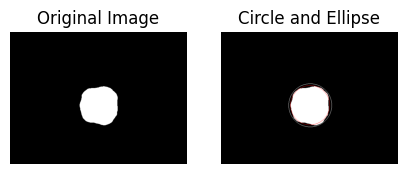

Eccentricity of ISIC_0031476_segmentation.png: 0.09


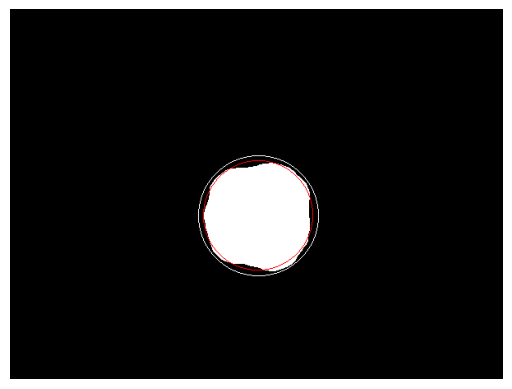

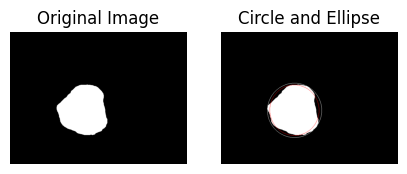

Eccentricity of ISIC_0026199_segmentation.png: 0.25


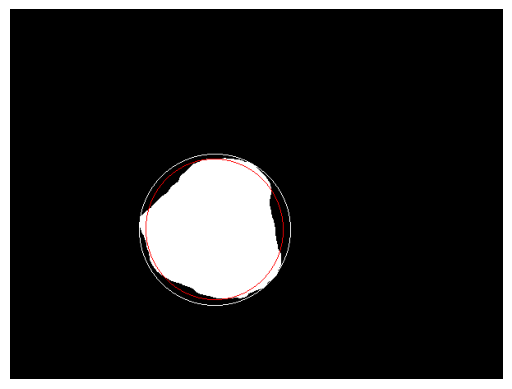

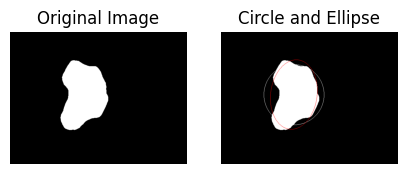

Eccentricity of ISIC_0031471_segmentation.png: 0.75


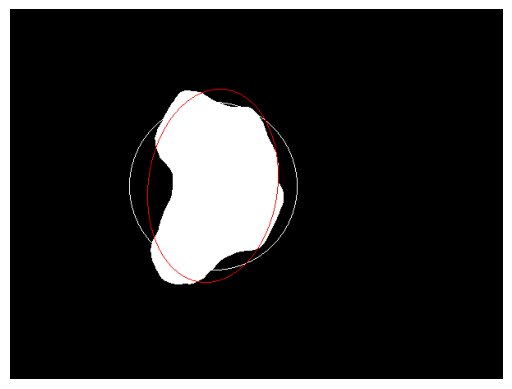

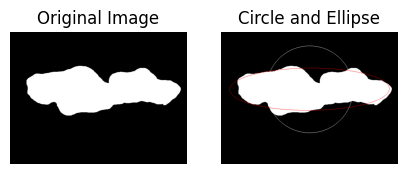

Eccentricity of ISIC_0028623_segmentation.png: 0.96


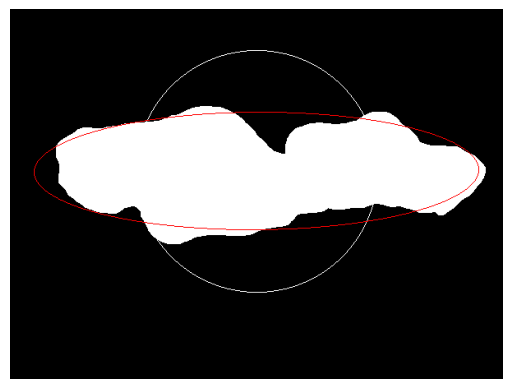

In [144]:
# Demonstrate the function with example images

specific = ['ISIC_0031476_segmentation.png',
            'ISIC_0026199_segmentation.png',
            'ISIC_0031471_segmentation.png',
            'ISIC_0028623_segmentation.png']

for file in specific:
    _,_,_,eccentricity = analyze_image_with_show(file)
    print(f'Eccentricity of {file}: {eccentricity:.2f}')

In [26]:
# For each image in the files, apply analyze_image function
results = []
for num, file in enumerate(files):
    print("File analysis started for:", file, "| Total:",len(files), "| Completion:", round((num+1)/len(files)*100, 2), "%")
    try:
        results.append(analyze_image(file))
    except:
        print("Error analyzing file: ", file)

File analysis started for: ISIC_0024306_segmentation.png | Total: 10015 | Completion: 0.01 %
File analysis started for: ISIC_0024307_segmentation.png | Total: 10015 | Completion: 0.02 %
File analysis started for: ISIC_0024308_segmentation.png | Total: 10015 | Completion: 0.03 %
File analysis started for: ISIC_0024309_segmentation.png | Total: 10015 | Completion: 0.04 %
File analysis started for: ISIC_0024310_segmentation.png | Total: 10015 | Completion: 0.05 %
File analysis started for: ISIC_0024311_segmentation.png | Total: 10015 | Completion: 0.06 %
File analysis started for: ISIC_0024312_segmentation.png | Total: 10015 | Completion: 0.07 %
File analysis started for: ISIC_0024313_segmentation.png | Total: 10015 | Completion: 0.08 %
File analysis started for: ISIC_0024314_segmentation.png | Total: 10015 | Completion: 0.09 %
File analysis started for: ISIC_0024315_segmentation.png | Total: 10015 | Completion: 0.1 %
File analysis started for: ISIC_0024316_segmentation.png | Total: 10015

In [27]:
# Create a dataframe from the results
df = pd.DataFrame(results, columns=['Image', 'Area', 'Perimeter', 'Eccentricity'])
df.head()

,Image,Area,Perimeter,Eccentricity
0,ISIC_0024306,92549.0,1329.266161,0.592868
1,ISIC_0024307,112543.0,1370.839754,0.378195
2,ISIC_0024308,99901.0,1482.437734,0.896703
3,ISIC_0024309,96230.0,1340.472222,0.616485
4,ISIC_0024310,65012.0,1425.567676,0.664720


In [30]:
# Metadata
metadata = pd.read_csv(r"C:\Users\wilpo\Downloads\archive\HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [28]:
# Export the dataframe to a csv file
df.to_csv('results.csv', index=False)

In [33]:
# Merge
metadata = metadata.merge(df, left_on='image_id', right_on='Image')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image,Area,Perimeter,Eccentricity
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419,85333.0,1251.785930,0.686623
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030,32326.0,754.488419,0.534008
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769,72118.0,1113.560533,0.646589
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661,21413.0,598.215295,0.676903
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633,102934.0,1274.011327,0.418797


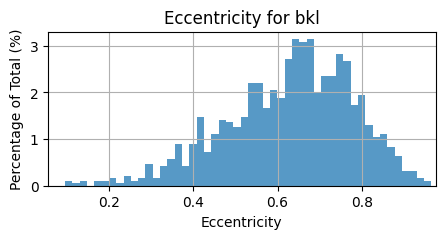

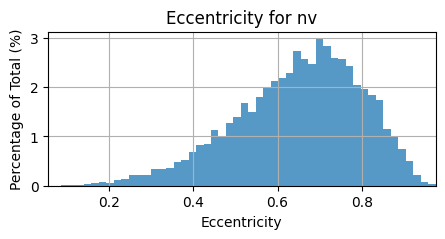

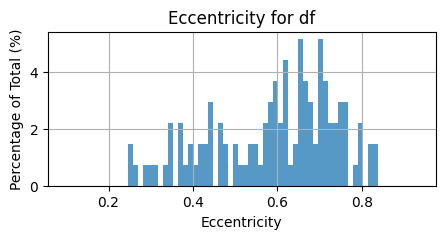

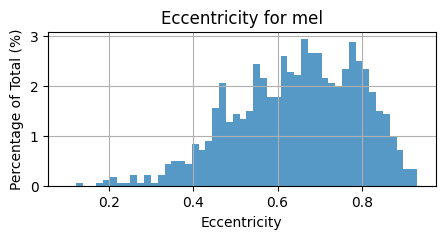

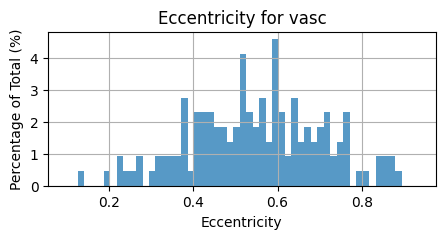

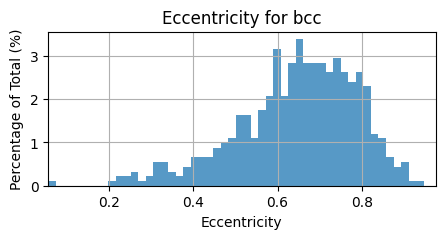

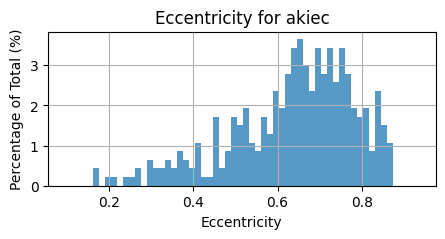

In [145]:
categories = metadata['dx'].unique()

global_min = metadata['Eccentricity'].min()
global_max = metadata['Eccentricity'].max()

for i, category in enumerate(categories):
    subset = metadata[metadata['dx'] == category]['Eccentricity']  # Filter data for each category
    plt.figure(figsize=(5, 2))

    plt.hist(subset, bins=50, alpha=0.75, label=f'{category} Eccentricity', density=True)  # Adjust bins as needed
    plt.xlabel('Eccentricity')
    plt.ylabel('Percentage of Total (%)')
    plt.title(f'Eccentricity for {category}')
    plt.grid(True)  # Optional: Adds a grid for better readability
    plt.xlim([global_min, global_max])

    plt.show()

plt.show()

In [70]:
# Create dictionary to map classes to definitions

diagnosis = {
    "akiec": {
        "definition": "Actinic Keratoses and Intraepithelial Carcinoma / Bowen's Disease",
        "cancerous" : True
    },
    "bcc": {
        "definition": "Basal Cell Carcinoma",
        "cancerous" : True
    },
    "bkl": {
        "definition": "Benign Keratosis-like Lesions",
        "cancerous" : False
    },
    "df": {
        "definition": "Dermatofibroma",
        "cancerous" : False
    },
    "mel": {
        "definition": "Melanoma",
        "cancerous" : True
    },
    "nv": {
        "definition": "Melanocytic Nevi",
        "cancerous" : False
    },
    "vasc": {
        "definition": "Vascular Lesions",
        "cancerous" : False
    }
}

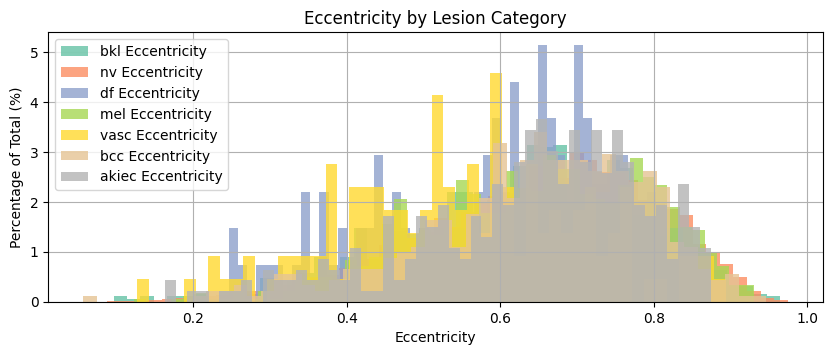

In [96]:
# Set up colors, ensure there are enough colors or use a colormap
colors = plt.cm.Set2(np.linspace(0, 1, len(categories)))

plt.figure(figsize=(10, 3.5))  # Set figure size

# Loop through categories and plot each histogram
for i, category in enumerate(categories):
    subset = metadata[metadata['dx'] == category]['Eccentricity']  # Filter data for each category
    
    # Plot histogram with adjusted bins and alpha for overlay
    plt.hist(subset, bins=50, alpha=0.8, color=colors[i], label=f'{category} Eccentricity', density=True)

# Adding labels, title, and grid
plt.xlabel('Eccentricity')
plt.ylabel('Percentage of Total (%)')
plt.title('Eccentricity by Lesion Category')
plt.grid(True)  # Adds a grid for better readability
plt.legend()  # Display the legend to identify categories
plt.show()

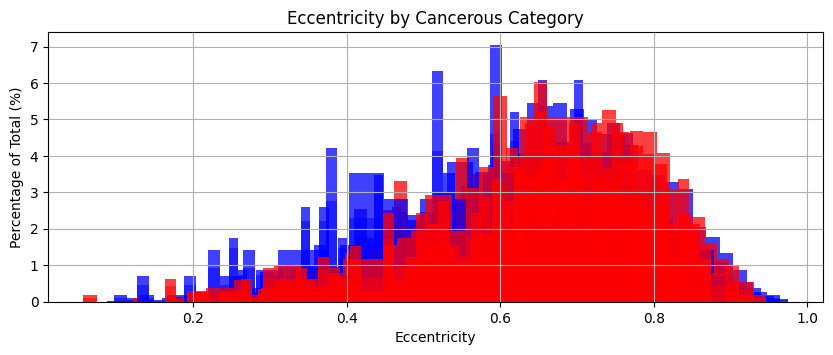

In [102]:
plt.figure(figsize=(10, 3.5))  # Set figure size

# Loop through categories and plot each histogram
for i, category in enumerate(categories):
    subset = metadata[metadata['dx'] == category]['Eccentricity']  # Filter data for each category
    # Determine color based on 'cancerous' status
    color = 'red' if diagnosis[category]['cancerous'] else 'blue'
    
    # Plot histogram with adjusted bins and alpha for overlay, normalize to show percentages
    n, bins, patches = plt.hist(subset, bins=50, alpha=0.20, color=color, label=f'{category} ({diagnosis[category]["definition"]})', density=True)
    plt.bar(bins[:-1], n * 100 * np.diff(bins), width=np.diff(bins), align='edge', alpha=0.75, color=color)

# Adding labels, title, and grid
plt.xlabel('Eccentricity')
plt.ylabel('Percentage of Total (%)')
plt.title('Eccentricity by Cancerous Category')
plt.grid(True)  # Adds a grid for better readability
plt.show()

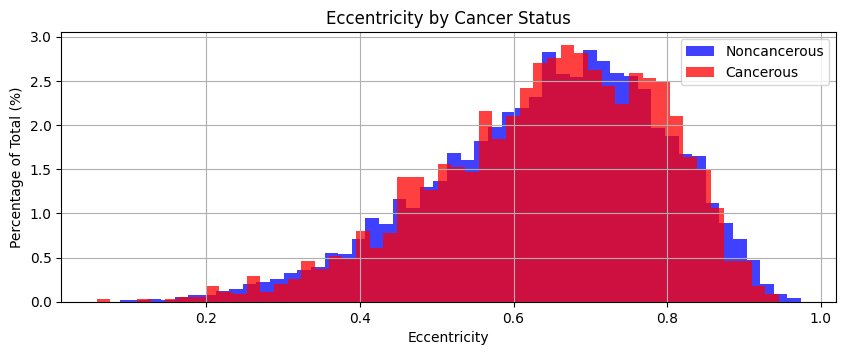

In [104]:
# Add a 'Cancerous' column to the DataFrame based on the 'dx' column and the diagnosis dictionary
metadata['Cancerous'] = metadata['dx'].apply(lambda x: diagnosis[x]['cancerous'])

# Group data into cancerous and noncancerous
cancerous_data = metadata[metadata['Cancerous'] == True]['Eccentricity']
noncancerous_data = metadata[metadata['Cancerous'] == False]['Eccentricity']

plt.figure(figsize=(10, 3.5))  # Set figure size

# Plot histogram for noncancerous data
plt.hist(noncancerous_data, bins=50, alpha=0.75, color='blue', label='Noncancerous', density=True)

# Plot histogram for cancerous data
plt.hist(cancerous_data, bins=50, alpha=0.75, color='red', label='Cancerous', density=True)

# Adding labels, title, and grid
plt.xlabel('Eccentricity')
plt.ylabel('Percentage of Total (%)')
plt.title('Eccentricity by Cancer Status')
plt.grid(True)  # Adds a grid for better readability
plt.legend()  # Display the legend to identify categories
plt.show()

In [108]:
# Group eccentricity data by 'dx' classification
groups = metadata.groupby('dx')['Eccentricity'].apply(list)

# Prepare data for Kruskal-Wallis Test
data_for_test = [group for group in groups]

# Perform the Kruskal-Wallis Test
stat, p_value = stats.kruskal(*data_for_test)

# Print results
print(f"Kruskal-Wallis Test Statistic: {stat}, P-value: {p_value}")


Kruskal-Wallis Test Statistic: 83.62678039624481, P-value: 6.353916127203598e-16


In [109]:
# Group eccentricity data by 'Cancerous' classification
groups = metadata.groupby('dx')['Cancerous'].apply(list)

# Prepare data for Kruskal-Wallis Test
data_for_test = [group for group in groups]

# Perform the Kruskal-Wallis Test
stat, p_value = stats.kruskal(*data_for_test)

# Print results
print(f"Kruskal-Wallis Test Statistic: {stat}, P-value: {p_value}")


Kruskal-Wallis Test Statistic: 10014.000000000013, P-value: 0.0
